In [1]:
import numpy as np
from scipy import sparse
from matplotlib import pyplot as plt
import time
import codecs

In [2]:
plt.rcParams['figure.figsize'] = (10, 5)

In [3]:
def save_results_to_tbl(results, sizes, fn, caption):
    with codecs.open(f'tbl/{fn}.tex', 'w', 'utf-8') as out:
        # head
        out.write('\\begin{table}[H]\n')
        out.write('\t\\centering\n')

        # body
        out.write('\t\\begin{tabular}{|c||' + 'c|' * len(sizes) + '}' + '\\hline\n')
        out.write('\t\tРозмір задачі & ' + ' & '.join(map(str, sizes)) + ' \\\\ \\hline \\hline\n')
        for algo, result in results.items():
            out.write('\t\t' + algo + ' & ' +
                      ' & '.join(map(lambda r: f'{r:.2f}'
                                     if type(r) is float else str(r), result.values())) +
                      ' \\\\ \\hline\n')
        out.write('\t\\end{tabular}\n')

        # tail
        out.write('\t\\caption{' + caption + '}\n')
        out.write('\\end{table}\n')


In [4]:
def save_results_to_tbl_pm(results, sizes, fn, caption):
    with codecs.open(f'tbl/{fn}.tex', 'w', 'utf-8') as out:
        # head
        out.write('\\begin{table}[H]\n')
        out.write('\t\\centering\n')

        # body
        end = ' \\\\ \\hline\n'
        out.write('\t\\begin{tabular}{|c||' + 'c|' * len(sizes) + '}' + '\\hline\n')
        out.write('\t\tРозмір задачі & ' + ' & '.join(map(str, sizes)) + ' \\\\ \\hline \\hline\n')
        for algo, result in results.items():
            out.write('\t\t' + algo + ' & ' +
                      ' & '.join(map(lambda r: f'{r[0]:.2f} $\\pm$ {r[1]:.2f}'
                                     if type(r[0]) is float else f'{r[0]} $\\pm$ {r[1]}', result.values())) +
                      ' \\\\ \\hline\n')
        out.write('\t\\end{tabular}\n')

        # tail
        out.write('\t\\caption{' + caption + '}\n')
        out.write('\\end{table}\n')


In [5]:
def save_results_to_img(results, sizes, fn, styles, title):
    plt.xscale('log')
    plt.yscale('log')
    for style, (algo, result) in zip(styles, results.items()):
        plt.plot(sizes, result.values(), style, label=algo)
    plt.xlabel('Розмір задачі', fontsize=16)
    plt.ylabel(title, fontsize=16)
    plt.legend(loc='best', fontsize=12)
    plt.grid(which='both')
    plt.savefig(f'img/{fn}.png', bbox_inches='tight')
    plt.show()


In [6]:
def save_results_to_img_pm(results, sizes, fn, styles, title):
    plt.xscale('log')
    plt.yscale('log')
    for style, (algo, result) in zip(styles, results.items()):
        plt.plot(sizes, [r[0] for r in result.values()], style, label=algo)
        plt.fill_between(sizes,
                         [r[0] - r[1] / 5 for r in result.values()], 
                         [r[0] + r[1] / 5 for r in result.values()],
                         color=style[0], alpha=.1)
    plt.xlabel('Розмір задачі', fontsize=16)
    plt.ylabel(title, fontsize=16)
    plt.legend(loc='best', fontsize=12)
    plt.grid(which='both')
    plt.savefig(f'img/{fn}.png', bbox_inches='tight')
    plt.show()


In [7]:
# pythonic way to implement generics (known as templates in C++)
from typing import Callable, TypeVar
T = TypeVar('T')

# Алгоритми

In [8]:
def korpelevich(x_initial: T,
                lambda_: float,
                A: Callable[[T], T],
                ProjectionOntoC: Callable[[T], T],
                tolerance: float = 1e-5,
                max_iterations: int = 1e4,
                debug: bool = False) -> T:
    start = time.time()

    # initialization
    iteration_n = 1
    x_current = x_initial

    while True:
        # step 1
        y_current = ProjectionOntoC(x_current - lambda_ * A(x_current))

        # stopping criterion
        if (np.linalg.norm(x_current - y_current) < tolerance or
            iteration_n == max_iterations):
            if debug:
                end = time.time()
                duration = end - start
                print(f'Took {iteration_n} iterations '
                      f'and {duration:.2f} seconds to converge.')
                return x_current, iteration_n, duration
            return x_current

        # step 2
        x_next = ProjectionOntoC(x_current - lambda_ * A(y_current))

        # next iteration
        iteration_n += 1
        x_current, x_next = x_next, None
        y_current = None


In [9]:
def tseng(x_initial: T,
          lambda_: float,
          A: Callable[[T], T],
          ProjectionOntoC: Callable[[T], T],
          tolerance: float = 1e-5,
          max_iterations: int = 1e4,
          debug: bool = False) -> T:
    start = time.time()

    # initialization
    iteration_n = 1
    x_current = x_initial

    while True:
        # step 1
        y_current = ProjectionOntoC(x_current - lambda_ * A(x_current))

        # stopping criterion
        if (np.linalg.norm(x_current - y_current) < tolerance or
            iteration_n == max_iterations):
            if debug:
                end = time.time()
                duration = end - start
                print(f'Took {iteration_n} iterations '
                      f'and {duration:.2f} seconds to converge.')
                return x_current, iteration_n, duration
            return x_current

        # step 2
        x_next = y_current - lambda_ * (A(y_current) - A(x_current))

        # next iteration
        iteration_n += 1
        x_current, x_next = x_next, None
        y_current = None


In [10]:
def cached_tseng(x_initial: T,
                 lambda_: float,
                 A: Callable[[T], T],
                 ProjectionOntoC: Callable[[T], T],
                 tolerance: float = 1e-5,
                 max_iterations: int = 1e4,
                 debug: bool = False) -> T:
    start = time.time()

    # initialization
    iteration_n = 1
    x_current = x_initial

    while True:
        # step 1
        A_x_current = A(x_current)
        y_current = ProjectionOntoC(x_current - lambda_ * A_x_current)

        # stopping criterion
        if (np.linalg.norm(x_current - y_current) < tolerance or
            iteration_n == max_iterations):
            if debug:
                end = time.time()
                duration = end - start
                print(f'Took {iteration_n} iterations '
                      f'and {duration:.2f} seconds to converge.')
                return x_current, iteration_n, duration
            return x_current

        # step 2
        x_next = y_current - lambda_ * (A(y_current) - A_x_current)

        # next iteration
        iteration_n += 1
        x_current, x_next = x_next, None
        y_current = None


In [11]:
def popov(x_initial: T,
          y_initial: T,
          lambda_: float,
          A: Callable[[T], T],
          ProjectionOntoC: Callable[[T], T],
          tolerance: float = 1e-5,
          max_iterations: int = 1e4,
          debug: bool = False) -> T:
    start = time.time()

    # initialization
    iteration_n = 1
    x_current = x_initial
    y_previous = y_initial

    while True:
        # step 1
        y_current = ProjectionOntoC(x_current - lambda_ * A(y_previous))
        
        # step 2
        x_next = ProjectionOntoC(x_current - lambda_ * A(y_current))

        # stopping criterion
        if (np.linalg.norm(x_current - y_current) < tolerance and
            np.linalg.norm(x_next - y_current) < tolerance or
            iteration_n == max_iterations):
            if debug:
                end = time.time()
                duration = end - start
                print(f'Took {iteration_n} iterations '
                      f'and {duration:.2f} seconds to converge.')
                return x_current, iteration_n, duration
            return x_current

        # next iteration
        iteration_n += 1
        x_current, x_next = x_next, None
        y_previous, y_current = y_current, None


In [12]:
def cached_popov(x_initial: T,
                 y_initial: T,
                 lambda_: float,
                 A: Callable[[T], T],
                 ProjectionOntoC: Callable[[T], T],
                 tolerance: float = 1e-5,
                 max_iterations: int = 1e4,
                 debug: bool = False) -> T:
    start = time.time()

    # initialization
    iteration_n = 1
    x_current = x_initial
    y_previous = y_initial
    A_y_previous, A_y_current = A(y_previous), None

    while True:
        # step 1
        y_current = ProjectionOntoC(x_current - lambda_ * A_y_previous)
        
        # step 2
        A_y_current = A(y_current)
        x_next = ProjectionOntoC(x_current - lambda_ * A_y_current)

        # stopping criterion
        if (np.linalg.norm(x_current - y_current) < tolerance and
            np.linalg.norm(x_next - y_current) < tolerance or
            iteration_n == max_iterations):
            if debug:
                end = time.time()
                duration = end - start
                print(f'Took {iteration_n} iterations '
                      f'and {duration:.2f} seconds to converge.')
                return x_current, iteration_n, duration
            return x_current

        # next iteration
        iteration_n += 1
        x_current, x_next = x_next, None
        y_previous, y_current = y_current, None
        A_y_previous, A_y_current = A_y_current, None


# Перша задача

In [13]:
def generate_matrix(size: int) -> np.matrix:
    matrix = np.zeros((size, size))
    for row in range(size):
        col = size - 1 - row
        if col < row:
            matrix[row, col] = 1
        if col > row:
            matrix[row, col] = -1
    return matrix


In [14]:
sizes = (1_000, 2_000, 5_000, 10_000)
algos = ('Корпелевич', 'Tseng', 'Кеш. Tseng', 'Попов', 'Кеш. Попов')
iters, times = {algo: {} for algo in algos}, {algo: {} for algo in algos}

In [15]:
for size in sizes:
    print(f'Розмір задачі = {size}:')
    a = generate_matrix(size)

    print('\tКорпелевич:', end=' ')
    _, iters['Корпелевич'][size], times['Корпелевич'][size] = korpelevich(
        x_initial=np.ones(size), lambda_=0.4,
        A=lambda x: a.dot(x), ProjectionOntoC=lambda x: x,
        tolerance=1e-3, max_iterations=1e4, debug=True)

    print('\tTseng:', end=' ')
    _, iters['Tseng'][size], times['Tseng'][size] = tseng(
        x_initial=np.ones(size), lambda_=0.4,
        A=lambda x: a.dot(x), ProjectionOntoC=lambda x: x,
        tolerance=1e-3, max_iterations=1e4, debug=True)

    print('\tКеш. Tseng:', end=' ')
    _, iters['Кеш. Tseng'][size], times['Кеш. Tseng'][size] = cached_tseng(
        x_initial=np.ones(size), lambda_=0.4,
        A=lambda x: a.dot(x), ProjectionOntoC=lambda x: x,
        tolerance=1e-3, max_iterations=1e4, debug=True)

    print('\tПопов:', end=' ')
    _, iters['Попов'][size], times['Попов'][size] = popov(
        x_initial=np.ones(size), y_initial=np.ones(size), lambda_=0.4,
        A=lambda x: a.dot(x), ProjectionOntoC=lambda x: x,
        tolerance=1e-3, max_iterations=1e4, debug=True)

    print('\tКеш. Попов:', end=' ')
    _, iters['Кеш. Попов'][size], times['Кеш. Попов'][size] = cached_popov(
        x_initial=np.ones(size), y_initial=np.ones(size), lambda_=0.4,
        A=lambda x: a.dot(x), ProjectionOntoC=lambda x: x,
        tolerance=1e-3, max_iterations=1e4, debug=True)

    print()
    

Розмір задачі = 1000:
	Корпелевич: Took 132 iterations and 0.11 seconds to converge.
	Tseng: Took 132 iterations and 0.10 seconds to converge.
	Кеш. Tseng: Took 132 iterations and 0.07 seconds to converge.
	Попов: Took 89 iterations and 0.08 seconds to converge.
	Кеш. Попов: Took 89 iterations and 0.03 seconds to converge.

Розмір задачі = 2000:
	Корпелевич: Took 137 iterations and 0.65 seconds to converge.
	Tseng: Took 137 iterations and 0.98 seconds to converge.
	Кеш. Tseng: Took 137 iterations and 0.71 seconds to converge.
	Попов: Took 92 iterations and 0.50 seconds to converge.
	Кеш. Попов: Took 92 iterations and 0.26 seconds to converge.

Розмір задачі = 5000:
	Корпелевич: Took 144 iterations and 4.95 seconds to converge.
	Tseng: Took 144 iterations and 7.13 seconds to converge.
	Кеш. Tseng: Took 144 iterations and 4.49 seconds to converge.
	Попов: Took 96 iterations and 2.98 seconds to converge.
	Кеш. Попов: Took 96 iterations and 1.52 seconds to converge.

Розмір задачі = 10000:

In [16]:
save_results_to_tbl(times, sizes,
    fn='1/time',
    caption='Час виконання, секунд')
save_results_to_tbl(iters, sizes,
    fn='1/iter',
    caption='Число ітерацій')

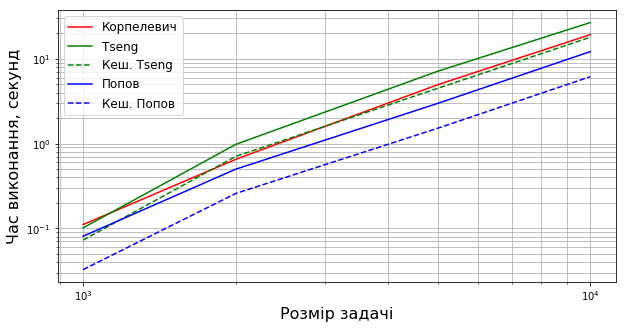

In [17]:
save_results_to_img(times, sizes,
    fn='1/time',
    styles=('r-', 'g-', 'g--', 'b-', 'b--'),
    title='Час виконання, секунд')

# Розріджені матриці

In [18]:
def generate_sparse_matrix(size: int) -> np.matrix:
    data, rows, cols = [], [], []
    for row in range(size):
        rows.append(row)
        col = size - 1 - row
        cols.append(col)
        if col < row:
            data.append(1)
        if col > row:
            data.append(-1)
    return sparse.coo_matrix((data, (rows, cols)), shape=(size, size))


In [19]:
sizes = (50_000, 100_000, 200_000, 500_000)
algos = ('Корпелевич', 'Tseng', 'Кеш. Tseng', 'Попов', 'Кеш. Попов')
iters, times = {algo: {} for algo in algos}, {algo: {} for algo in algos}

In [20]:
for size in sizes:
    print(f'Розмір задачі = {size}:')
    a = generate_sparse_matrix(size)

    print('\tКорпелевич:', end=' ')
    _, iters['Корпелевич'][size], times['Корпелевич'][size] = korpelevich(
        x_initial=np.ones(size), lambda_=0.4,
        A=lambda x: a.dot(x), ProjectionOntoC=lambda x: x,
        tolerance=1e-3, max_iterations=1e4, debug=True)

    print('\tTseng:', end=' ')
    _, iters['Tseng'][size], times['Tseng'][size] = tseng(
        x_initial=np.ones(size), lambda_=0.4,
        A=lambda x: a.dot(x), ProjectionOntoC=lambda x: x,
        tolerance=1e-3, max_iterations=1e4, debug=True)

    print('\tКеш. Tseng:', end=' ')
    _, iters['Кеш. Tseng'][size], times['Кеш. Tseng'][size] = cached_tseng(
        x_initial=np.ones(size), lambda_=0.4,
        A=lambda x: a.dot(x), ProjectionOntoC=lambda x: x,
        tolerance=1e-3, max_iterations=1e4, debug=True)
    
    print('\tPopov:', end=' ')
    _, iters['Попов'][size], times['Попов'][size] = popov(
        x_initial=np.ones(size), y_initial=np.ones(size), lambda_=0.4,
        A=lambda x: a.dot(x), ProjectionOntoC=lambda x: x,
        tolerance=1e-3, max_iterations=1e4, debug=True)

    print('\tКеш. Попов:', end=' ')
    _, iters['Кеш. Попов'][size], times['Кеш. Попов'][size] = cached_popov(
        x_initial=np.ones(size), y_initial=np.ones(size), lambda_=0.4,
        A=lambda x: a.dot(x), ProjectionOntoC=lambda x: x,
        tolerance=1e-3, max_iterations=1e4, debug=True)
    
    print()


Розмір задачі = 50000:
	Корпелевич: Took 159 iterations and 0.07 seconds to converge.
	Tseng: Took 159 iterations and 0.10 seconds to converge.
	Кеш. Tseng: Took 159 iterations and 0.07 seconds to converge.
	Popov: Took 106 iterations and 0.04 seconds to converge.
	Кеш. Попов: Took 106 iterations and 0.03 seconds to converge.

Розмір задачі = 100000:
	Корпелевич: Took 164 iterations and 0.30 seconds to converge.
	Tseng: Took 164 iterations and 0.39 seconds to converge.
	Кеш. Tseng: Took 164 iterations and 0.21 seconds to converge.
	Popov: Took 109 iterations and 0.14 seconds to converge.
	Кеш. Попов: Took 109 iterations and 0.19 seconds to converge.

Розмір задачі = 200000:
	Корпелевич: Took 169 iterations and 1.69 seconds to converge.
	Tseng: Took 169 iterations and 2.19 seconds to converge.
	Кеш. Tseng: Took 169 iterations and 1.39 seconds to converge.
	Popov: Took 112 iterations and 0.85 seconds to converge.
	Кеш. Попов: Took 112 iterations and 1.06 seconds to converge.

Розмір зада

In [21]:
save_results_to_tbl(times, sizes,
    fn='1/sparse/time',
    caption='Час виконання, секунд')
save_results_to_tbl(iters, sizes,
    fn='1/sparse/iter',
    caption='Число ітерацій')

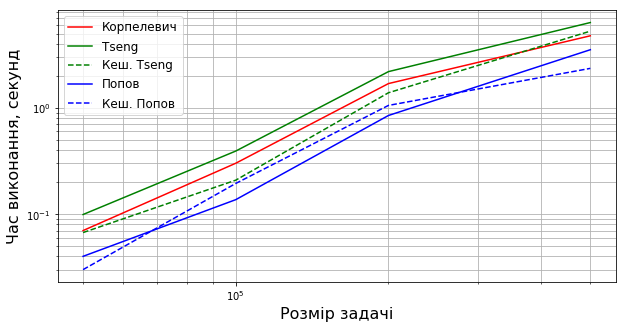

In [22]:
save_results_to_img(times, sizes,
    fn='1/sparse/time',
    styles=('r-', 'g-', 'g--', 'b-', 'b--'),
    title='Час виконання, секунд')

# Друга задача

In [23]:
def generate_random_matrix(size: int) -> np.matrix:
    a = np.random.uniform(-5, 5, (size, size))
    b = np.random.uniform(-5, 5, (size, size))
    # skew-symmetric
    for row in range(size):
        for col in range(row):
            b[col, row] = -b[row, col]
    d = np.diag(np.random.uniform(0, .3, size))
    q = np.random.uniform(-500, 0, size)
    return a.dot(a.T) + b + d, q


In [24]:
def ProjectionOntoProbabilitySymplex(x: np.array) -> np.array:
    dimensionality = x.shape[0]
    x /= dimensionality
    sorted_x = np.flip(np.sort(x))
    prefix_sum = np.cumsum(sorted_x)
    to_compare = sorted_x + (1 - prefix_sum) / np.arange(1, dimensionality + 1)
    k = 0
    for j in range(1, dimensionality):
        if to_compare[j] > 0:
            k = j
    return dimensionality * np.maximum(np.zeros(dimensionality),
                                       x + (to_compare[k] - sorted_x[k]))

In [25]:
sizes = (100, 200, 500, 1000)
algos = ('Корпелевич', 'Tseng', 'Кеш. Tseng', 'Попов', 'Кеш. Попов')
iters, times = {algo: {} for algo in algos}, {algo: {} for algo in algos}

In [26]:
for size in sizes:
    print(f'Розмір задачі = {size}:')

    for algo in algos:
        iters[algo][size] = []
        times[algo][size] = []
 
    for _ in range(5):
        print(f'\tTry #{_ + 1}:')

        np.random.seed(_)
        M, q = generate_random_matrix(size)

        print('\t\tКорпелевич:', end=' ')
        _, iter_, time_ = korpelevich(
            x_initial=np.ones(size), lambda_=.4/np.linalg.norm(M),
            A=lambda x: M.dot(x) + q, ProjectionOntoC=ProjectionOntoProbabilitySymplex,
            tolerance=1e-3, max_iterations=1e4, debug=True)
        iters['Корпелевич'][size].append(iter_)
        times['Корпелевич'][size].append(time_)

        print('\t\tTseng:', end=' ')
        _, iter_, time_ = tseng(
            x_initial=np.ones(size), lambda_=.4/np.linalg.norm(M),
            A=lambda x: M.dot(x) + q, ProjectionOntoC=ProjectionOntoProbabilitySymplex,
            tolerance=1e-3, max_iterations=1e4, debug=True)
        iters['Tseng'][size].append(iter_)
        times['Tseng'][size].append(time_)

        print('\t\tКеш. Tseng:', end=' ')
        _, iter_, time_ = cached_tseng(
            x_initial=np.ones(size), lambda_=.4/np.linalg.norm(M),
            A=lambda x: M.dot(x) + q, ProjectionOntoC=ProjectionOntoProbabilitySymplex,
            tolerance=1e-3, max_iterations=1e4, debug=True)
        iters['Кеш. Tseng'][size].append(iter_)
        times['Кеш. Tseng'][size].append(time_)

        print('\t\tПопов:', end=' ')
        _, iter_, time_ = popov(
            x_initial=np.ones(size), y_initial=np.ones(size), lambda_=.4/np.linalg.norm(M),
            A=lambda x: M.dot(x) + q, ProjectionOntoC=ProjectionOntoProbabilitySymplex,
            tolerance=1e-3, max_iterations=1e4, debug=True)
        iters['Попов'][size].append(iter_)
        times['Попов'][size].append(time_)

        print('\t\tКеш. Попов:', end=' ')
        _, iter_, time_ = cached_popov(
            x_initial=np.ones(size), y_initial=np.ones(size), lambda_=.4/np.linalg.norm(M),
            A=lambda x: M.dot(x) + q, ProjectionOntoC=ProjectionOntoProbabilitySymplex,
            tolerance=1e-3, max_iterations=1e4, debug=True)
        iters['Кеш. Попов'][size].append(iter_)
        times['Кеш. Попов'][size].append(time_)

        print()

    print()

Розмір задачі = 100:
	Try #1:
		Корпелевич: Took 967 iterations and 0.53 seconds to converge.
		Tseng: Took 967 iterations and 0.47 seconds to converge.
		Кеш. Tseng: Took 967 iterations and 0.33 seconds to converge.
		Попов: Took 967 iterations and 0.23 seconds to converge.
		Кеш. Попов: Took 967 iterations and 0.18 seconds to converge.

	Try #2:
		Корпелевич: Took 1151 iterations and 0.31 seconds to converge.
		Tseng: Took 1151 iterations and 0.27 seconds to converge.
		Кеш. Tseng: Took 1151 iterations and 0.20 seconds to converge.
		Попов: Took 1151 iterations and 0.29 seconds to converge.
		Кеш. Попов: Took 1151 iterations and 0.22 seconds to converge.

	Try #3:
		Корпелевич: Took 1086 iterations and 0.27 seconds to converge.
		Tseng: Took 1086 iterations and 0.26 seconds to converge.
		Кеш. Tseng: Took 1086 iterations and 0.41 seconds to converge.
		Попов: Took 1086 iterations and 0.58 seconds to converge.
		Кеш. Попов: Took 1086 iterations and 0.51 seconds to converge.

	Try #4:


In [27]:
for algo in algos:
    for size in sizes:
        iters[algo][size] = (int(np.mean(iters[algo][size])), int(np.std(iters[algo][size])))
        times[algo][size] = (np.mean(times[algo][size]), np.std(times[algo][size]))

In [28]:
save_results_to_tbl_pm(times, sizes,
    fn='2/time',
    caption='Час виконання, секунд')
save_results_to_tbl_pm(iters, sizes,
    fn='2/iter',
    caption='Число ітерацій')

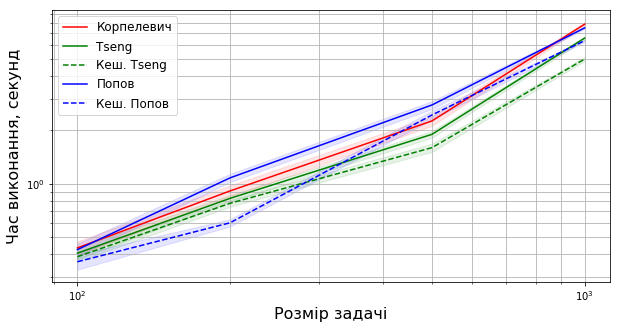

In [29]:
save_results_to_img_pm(times, sizes,
    fn='2/time',
    styles=('r-', 'g-', 'g--', 'b-', 'b--'),
    title='Час виконання, секунд')

# Адаптивні алгоритми

In [30]:
def adaptive_korpelevich(x_initial: T,
                         tau: float,
                         lambda_initial: float,
                         A: Callable[[T], T],
                         ProjectionOntoC: Callable[[T], T],
                         tolerance: float = 1e-5,
                         max_iterations: int = 1e4,
                         debug: bool = False) -> T:
    start = time.time()

    # initialization
    iteration_n = 1
    x_current = x_initial
    lambda_current = lambda_initial

    while True:
        # step 1
        y_current = ProjectionOntoC(x_current - lambda_current * A(x_current))

        # stopping criterion
        if (np.linalg.norm(x_current - y_current) < tolerance or
            iteration_n == max_iterations):
            if debug:
                end = time.time()
                duration = end - start
                print(f'Took {iteration_n} iterations '
                      f'and {duration:.2f} seconds to converge.')
                return x_current, iteration_n, duration
            return x_current

        # step 2
        x_next = ProjectionOntoC(x_current - lambda_current * A(y_current))

        # step 3
        if (A(x_current) - A(y_current)).dot(x_next - y_current) <= 0:
            lambda_next = lambda_current
        else:
            lambda_next = min(lambda_current, tau / 2 * 
                (np.linalg.norm(x_current - y_current) ** 2 + 
                 np.linalg.norm(x_next - y_current) ** 2) /
                    (A(x_current) - A(y_current)).dot(x_next - y_current))
        
        # next iteration
        iteration_n += 1
        x_current, x_next = x_next, None
        y_current = None
        lambda_current, lambda_next = lambda_next, None


In [31]:
def cached_adaptive_korpelevich(x_initial: T,
                                tau: float,
                                lambda_initial: float,
                                A: Callable[[T], T],
                                ProjectionOntoC: Callable[[T], T],
                                tolerance: float = 1e-5,
                                max_iterations: int = 1e4,
                                debug: bool = False) -> T:
    start = time.time()

    # initialization
    iteration_n = 1
    x_current = x_initial
    lambda_current = lambda_initial
    A_x_current, A_y_current = None, None

    while True:
        # step 1
        A_x_current = A(x_current)
        y_current = ProjectionOntoC(x_current - lambda_current * A_x_current)

        # stopping criterion
        if (np.linalg.norm(x_current - y_current) < tolerance or
            iteration_n == max_iterations):
            if debug:
                end = time.time()
                duration = end - start
                print(f'Took {iteration_n} iterations '
                      f'and {duration:.2f} seconds to converge.')
                return x_current, iteration_n, duration
            return x_current

        # step 2
        A_y_current = A(y_current)
        x_next = ProjectionOntoC(x_current - lambda_current * A_y_current)

        # step 3
        product = (A_x_current - A_y_current).dot(x_next - y_current)
        if product <= 0:
            lambda_next = lambda_current
        else:
            lambda_next = min(lambda_current, tau / 2 *
                (np.linalg.norm(x_current - y_current) ** 2 + 
                 np.linalg.norm(x_next - y_current) ** 2) / product)
        
        # next iteration
        iteration_n += 1
        x_current, x_next = x_next, None
        y_current = None
        lambda_current, lambda_next = lambda_next, None
        A_x_current, A_y_current = None, None


In [32]:
def adaptive_tseng(x_initial: T,
                   tau: float,
                   lambda_initial: float,
                   A: Callable[[T], T],
                   ProjectionOntoC: Callable[[T], T],
                   tolerance: float = 1e-5,
                   max_iterations: int = 1e4,
                   debug: bool = False) -> T:
    start = time.time()

    # initialization
    iteration_n = 1
    x_current = x_initial
    lambda_current = lambda_initial

    while True:
        # step 1
        y_current = ProjectionOntoC(x_current - lambda_current * A(x_current))

        # stopping criterion
        if (np.linalg.norm(x_current - y_current) < tolerance or
            iteration_n == max_iterations):
            if debug:
                end = time.time()
                duration = end - start
                print(f'Took {iteration_n} iterations '
                      f'and {duration:.2f} seconds to converge.')
                return x_current, iteration_n, duration
            return x_current

        # step 2
        x_next = y_current - lambda_current * (A(y_current) - A(x_current))

        # step 3
        # if np.all(A(x_current) == A(y_current)):
        if np.linalg.norm(A(x_current) - A(y_current)) < tolerance:
            lambda_next = lambda_current
        else:
            lambda_next = min(lambda_current, tau *
                np.linalg.norm(x_current - y_current) /
                np.linalg.norm(A(x_current) - A(y_current)))
        
        # next iteration
        iteration_n += 1
        x_current, x_next = x_next, None
        y_current = None
        lambda_current, lambda_next = lambda_next, None


In [33]:
def cached_adaptive_tseng(x_initial: T,
                          tau: float,
                          lambda_initial: float,
                          A: Callable[[T], T],
                          ProjectionOntoC: Callable[[T], T],
                          tolerance: float = 1e-5,
                          max_iterations: int = 1e4,
                          debug: bool = False) -> T:
    start = time.time()

    # initialization
    iteration_n = 1
    x_current = x_initial
    lambda_current = lambda_initial
    A_x_current = None
    A_y_current = None

    while True:
        # step 1
        A_x_current = A(x_current)
        y_current = ProjectionOntoC(x_current - lambda_current * A_x_current)

        # stopping criterion
        if (np.linalg.norm(x_current - y_current) < tolerance or
            iteration_n == max_iterations):
            if debug:
                end = time.time()
                duration = end - start
                print(f'Took {iteration_n} iterations '
                      f'and {duration:.2f} seconds to converge.')
                return x_current, iteration_n, duration
            return x_current

        # step 2
        A_y_current = A(y_current)
        x_next = y_current - lambda_current * (A_y_current - A_x_current)

        # step 3
        # if np.all(A_x_current == A_y_current):
        if np.linalg.norm(A_x_current - A_y_current) < tolerance:
            lambda_next = lambda_current
        else:
            lambda_next = min(lambda_current, tau *
                np.linalg.norm(x_current - y_current) /
                np.linalg.norm(A_x_current - A_y_current))
        
        # next iteration
        iteration_n += 1
        x_current, x_next = x_next, None
        y_current = None
        lambda_current, lambda_next = lambda_next, None
        A_x_current, A_y_current = None, None


In [34]:
def adaptive_popov(x_initial: T,
                   y_initial: T,
                   tau: float,
                   lambda_initial: float,
                   A: Callable[[T], T],
                   ProjectionOntoC: Callable[[T], T],
                   tolerance: float = 1e-5,
                   max_iterations: int = 1e4,
                   debug: bool = False) -> T:
    start = time.time()

    # initialization
    iteration_n = 1
    x_current = x_initial
    y_previous = y_initial
    lambda_current = lambda_initial

    while True:
        # step 1
        y_current = ProjectionOntoC(x_current - lambda_current * A(y_previous))
        
        # step 2
        x_next = ProjectionOntoC(x_current - lambda_current * A(y_current))

        # stopping criterion
        if (np.linalg.norm(x_current - y_current) < tolerance and
            np.linalg.norm(x_next - y_current) < tolerance or
            iteration_n == max_iterations):
            if debug:
                end = time.time()
                duration = end - start
                print(f'Took {iteration_n} iterations '
                      f'and {duration:.2f} seconds to converge.')
                return x_current, iteration_n, duration
            return x_current

        # step 3
        if (A(y_previous) - A(y_current)).dot(x_next - y_current) <= 0:
            lambda_next = lambda_current
        else:
            lambda_next = min(lambda_current, tau / 2 *
                (np.linalg.norm(y_previous - y_current) ** 2 +
                 np.linalg.norm(x_next - y_current) ** 2) /
                    (A(y_previous) - A(y_current)).dot(x_next - y_current))
        
        # next iteration
        iteration_n += 1
        x_current, x_next = x_next, None
        y_previous, y_current = y_current, None
        lambda_current, lambda_next = lambda_next, None


In [35]:
def cached_adaptive_popov(x_initial: T,
                          y_initial: T,
                          tau: float,
                          lambda_initial: float,
                          A: Callable[[T], T],
                          ProjectionOntoC: Callable[[T], T],
                          tolerance: float = 1e-5,
                          max_iterations: int = 1e4,
                          debug: bool = False) -> T:
    start = time.time()

    # initialization
    iteration_n = 1
    x_current = x_initial
    y_previous = y_initial
    lambda_current = lambda_initial
    A_y_previous, A_y_current = A(y_previous), None

    while True:
        # step 1
        y_current = ProjectionOntoC(x_current - lambda_current * A_y_previous)
        
        # step 2
        A_y_current = A(y_current)
        x_next = ProjectionOntoC(x_current - lambda_current * A_y_current)

        # stopping criterion
        if (np.linalg.norm(x_current - y_current) < tolerance and
            np.linalg.norm(x_next - y_current) < tolerance or
            iteration_n == max_iterations):
            if debug:
                end = time.time()
                duration = end - start
                print(f'Took {iteration_n} iterations '
                      f'and {duration:.2f} seconds to converge.')
                return x_current, iteration_n, duration
            return x_current

        # step 3
        product = (A_y_previous - A_y_current).dot(x_next - y_current)
        if product <= 0:
            lambda_next = lambda_current
        else:
            lambda_next = min(lambda_current, tau / 2 *
                (np.linalg.norm(y_previous - y_current) ** 2 +
                 np.linalg.norm(x_next - y_current) ** 2) / product)
        
        # next iteration
        iteration_n += 1
        x_current, x_next = x_next, None
        y_previous, y_current = y_current, None
        lambda_current, lambda_next = lambda_next, None
        A_y_previous, A_y_current = A_y_current, None


In [36]:
sizes = (1_000, 2_000, 5_000, 10_000)
algos = ('Адапт. Корпелевич', 'Кеш. адапт. Корпелевич',
         'Адапт. Tseng', 'Кеш. адапт. Tseng',
         'Адапт. Попов', 'Кеш. адапт. Попов')
iters, times = {algo: {} for algo in algos}, {algo: {} for algo in algos}

In [37]:
for size in sizes:
    print(f'Розмір задачі = {size}:')
    a = generate_matrix(size)

    print('\tАдапт. Корпелевич:', end=' ')
    _, iters['Адапт. Корпелевич'][size], times['Адапт. Корпелевич'][size] = \
          adaptive_korpelevich(x_initial=np.ones(size), tau=.9, lambda_initial=1,
                               A=lambda x: a.dot(x), ProjectionOntoC=lambda x: x,
                               tolerance=1e-3, max_iterations=1e4, debug=True)

    print('\tКеш. адапт. Корпелевич:', end=' ')
    _, iters['Кеш. адапт. Корпелевич'][size], times['Кеш. адапт. Корпелевич'][size] = \
          cached_adaptive_korpelevich(x_initial=np.ones(size), tau=.9, lambda_initial=1,
                                      A=lambda x: a.dot(x), ProjectionOntoC=lambda x: x,
                                      tolerance=1e-3, max_iterations=1e4, debug=True)

    print('\tАдапт. Tseng:', end=' ')
    _, iters['Адапт. Tseng'][size], times['Адапт. Tseng'][size] = \
          adaptive_tseng(x_initial=np.ones(size), tau=.9, lambda_initial=1,
                         A=lambda x: a.dot(x), ProjectionOntoC=lambda x: x,
                         tolerance=1e-3, max_iterations=1e4, debug=True)

    print('\tКеш. адапт. Tseng:', end=' ')
    _, iters['Кеш. адапт. Tseng'][size], times['Кеш. адапт. Tseng'][size] = \
          cached_adaptive_tseng(x_initial=np.ones(size), tau=.9, lambda_initial=1,
                                A=lambda x: a.dot(x), ProjectionOntoC=lambda x: x,
                                tolerance=1e-3, max_iterations=1e4, debug=True)

    print('\tАдапт. Попов:', end=' ')
    _, iters['Адапт. Попов'][size], times['Адапт. Попов'][size] = \
          adaptive_popov(x_initial=np.ones(size), y_initial=np.ones(size),
                         tau=.3, lambda_initial=1,
                         A=lambda x: a.dot(x), ProjectionOntoC=lambda x: x,
                         tolerance=1e-3, max_iterations=1e4, debug=True)

    print('\tКеш. адапт. Попов:', end=' ')
    _, iters['Кеш. адапт. Попов'][size], times['Кеш. адапт. Попов'][size] = \
          cached_adaptive_popov(x_initial=np.ones(size), y_initial=np.ones(size),
                                tau=.3, lambda_initial=1,
                                A=lambda x: a.dot(x), ProjectionOntoC=lambda x: x,
                                tolerance=1e-3, max_iterations=1e4, debug=True)
    
    print()


Розмір задачі = 1000:
	Адапт. Корпелевич: Took 125 iterations and 0.21 seconds to converge.
	Кеш. адапт. Корпелевич: Took 125 iterations and 0.11 seconds to converge.
	Адапт. Tseng: Took 125 iterations and 0.27 seconds to converge.
	Кеш. адапт. Tseng: Took 125 iterations and 0.07 seconds to converge.
	Адапт. Попов: Took 179 iterations and 0.31 seconds to converge.
	Кеш. адапт. Попов: Took 179 iterations and 0.07 seconds to converge.

Розмір задачі = 2000:
	Адапт. Корпелевич: Took 129 iterations and 1.71 seconds to converge.
	Кеш. адапт. Корпелевич: Took 129 iterations and 0.56 seconds to converge.
	Адапт. Tseng: Took 129 iterations and 1.91 seconds to converge.
	Кеш. адапт. Tseng: Took 129 iterations and 0.57 seconds to converge.
	Адапт. Попов: Took 185 iterations and 2.45 seconds to converge.
	Кеш. адапт. Попов: Took 185 iterations and 0.54 seconds to converge.

Розмір задачі = 5000:
	Адапт. Корпелевич: Took 135 iterations and 12.70 seconds to converge.
	Кеш. адапт. Корпелевич: Took 1

In [38]:
save_results_to_tbl(times, sizes,
    fn='1/adapt/time',
    caption='Час виконання, секунд')
save_results_to_tbl(iters, sizes,
    fn='1/adapt/iter',
    caption='Число ітерацій')

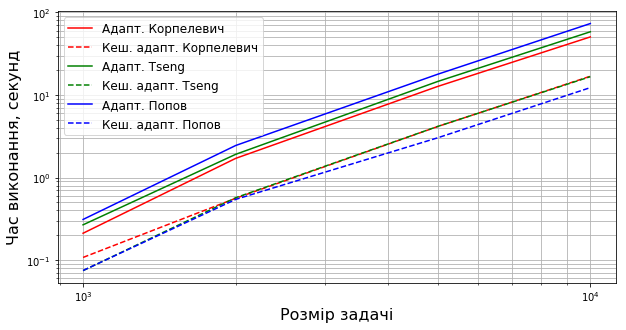

In [39]:
save_results_to_img(times, sizes,
    fn='1/adapt/time',
    styles=('r-', 'r--', 'g-', 'g--', 'b-', 'b--'),
    title='Час виконання, секунд')

In [40]:
sizes = (50_000, 100_000, 200_000, 500_000)
algos = ('Адапт. Корпелевич', 'Кеш. адапт. Корпелевич',
         'Адапт. Tseng', 'Кеш. адапт. Tseng',
         'Адапт. Попов', 'Кеш. адапт. Попов')
iters, times = {algo: {} for algo in algos}, {algo: {} for algo in algos}

In [41]:
for size in sizes:
    print(f'Розмір задачі = {size}:')
    a = generate_sparse_matrix(size)

    print('\tАдапт. Корпелевич:', end=' ')
    _, iters['Адапт. Корпелевич'][size], times['Адапт. Корпелевич'][size] = \
          adaptive_korpelevich(x_initial=np.ones(size), tau=.4, lambda_initial=1,
                               A=lambda x: a.dot(x), ProjectionOntoC=lambda x: x,
                               tolerance=1e-3, max_iterations=1e4, debug=True)

    print('\tКеш. адапт. Корпелевич:', end=' ')
    _, iters['Кеш. адапт. Корпелевич'][size], times['Кеш. адапт. Корпелевич'][size] = \
          cached_adaptive_korpelevich(x_initial=np.ones(size), tau=.4, lambda_initial=1,
                                      A=lambda x: a.dot(x), ProjectionOntoC=lambda x: x,
                                      tolerance=1e-3, max_iterations=1e4, debug=True)

    print('\tАдапт. Tseng:', end=' ')
    _, iters['Адапт. Tseng'][size], times['Адапт. Tseng'][size] = \
          adaptive_tseng(x_initial=np.ones(size), tau=.4, lambda_initial=1,
                         A=lambda x: a.dot(x), ProjectionOntoC=lambda x: x,
                         tolerance=1e-3, max_iterations=1e4, debug=True)

    print('\tКеш. адапт. Tseng:', end=' ')
    _, iters['Кеш. адапт. Tseng'][size], times['Кеш. адапт. Tseng'][size] = \
          cached_adaptive_tseng(x_initial=np.ones(size), tau=.4, lambda_initial=1,
                                A=lambda x: a.dot(x), ProjectionOntoC=lambda x: x,
                                tolerance=1e-3, max_iterations=1e4, debug=True)

    print('\tАдапт. Попов:', end=' ')
    _, iters['Адапт. Попов'][size], times['Адапт. Попов'][size] = \
          adaptive_popov(x_initial=np.ones(size), y_initial=np.ones(size),
                         tau=.4, lambda_initial=1,
                         A=lambda x: a.dot(x), ProjectionOntoC=lambda x: x,
                         tolerance=1e-3, max_iterations=1e4, debug=True)

    print("\tКеш. адапт. Попов: ", end="")
    _, iters['Кеш. адапт. Попов'][size], times['Кеш. адапт. Попов'][size] = \
          cached_adaptive_popov(x_initial=np.ones(size), y_initial=np.ones(size),
                                tau=.4, lambda_initial=1,
                                A=lambda x: a.dot(x), ProjectionOntoC=lambda x: x,
                                tolerance=1e-3, max_iterations=1e4, debug=True)
    
    print()


Розмір задачі = 50000:
	Адапт. Корпелевич: Took 160 iterations and 0.20 seconds to converge.
	Кеш. адапт. Корпелевич: Took 160 iterations and 0.23 seconds to converge.
	Адапт. Tseng: Took 160 iterations and 0.28 seconds to converge.
	Кеш. адапт. Tseng: Took 160 iterations and 0.10 seconds to converge.
	Адапт. Попов: Took 108 iterations and 0.14 seconds to converge.
	Кеш. адапт. Попов: Took 108 iterations and 0.06 seconds to converge.

Розмір задачі = 100000:
	Адапт. Корпелевич: Took 165 iterations and 1.94 seconds to converge.
	Кеш. адапт. Корпелевич: Took 165 iterations and 1.15 seconds to converge.
	Адапт. Tseng: Took 165 iterations and 0.93 seconds to converge.
	Кеш. адапт. Tseng: Took 165 iterations and 0.49 seconds to converge.
	Адапт. Попов: Took 111 iterations and 0.53 seconds to converge.
	Кеш. адапт. Попов: Took 111 iterations and 0.21 seconds to converge.

Розмір задачі = 200000:
	Адапт. Корпелевич: Took 170 iterations and 4.69 seconds to converge.
	Кеш. адапт. Корпелевич: To

In [42]:
save_results_to_tbl(times, sizes,
    fn='1/sparse/adapt/time',
    caption='Час виконання, секунд')
save_results_to_tbl(iters, sizes,
    fn='1/sparse/adapt/iter',
    caption='Число ітерацій')

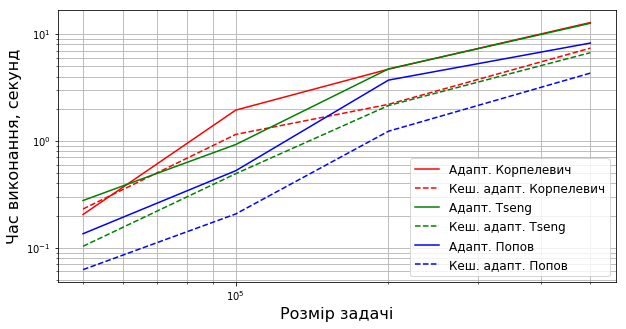

In [43]:
save_results_to_img(times, sizes,
    fn='1/sparse/adapt/time',
    styles=('r-', 'r--', 'g-', 'g--', 'b-', 'b--'),
    title='Час виконання, секунд')

In [44]:
sizes = (100, 200, 500, 1000)
algos = ('Адапт. Корпелевич', 'Кеш. адапт. Корпелевич',
         'Адапт. Tseng', 'Кеш. адапт. Tseng',
         'Адапт. Попов', 'Кеш. адапт. Попов')
iters, times = {algo: {} for algo in algos}, {algo: {} for algo in algos}

In [45]:
for size in sizes:
    print(f'Розмір задачі = {size}:')

    for algo in algos:
        iters[algo][size] = []
        times[algo][size] = []
 
    for _ in range(5):
        print(f'\tTry #{_ + 1}:')

        np.random.seed(_)
        M, q = generate_random_matrix(size)
        
        print('\t\tАдапт. Корпелевич:', end=' ')
        _, iter_, time_ = adaptive_korpelevich(
            x_initial=np.ones(size), tau=.4, lambda_initial=1,
            A=lambda x: M.dot(x) + q, ProjectionOntoC=ProjectionOntoProbabilitySymplex,
            tolerance=1e-3, max_iterations=1e4, debug=True)
        iters['Адапт. Корпелевич'][size].append(iter_)
        times['Адапт. Корпелевич'][size].append(time_)

        print('\t\tКеш. адапт. Корпелевич:', end=' ')
        _, iter_, time_ = cached_adaptive_korpelevich(
            x_initial=np.ones(size), tau=.4, lambda_initial=1,
            A=lambda x: M.dot(x) + q, ProjectionOntoC=ProjectionOntoProbabilitySymplex,
            tolerance=1e-3, max_iterations=1e4, debug=True)
        iters['Кеш. адапт. Корпелевич'][size].append(iter_)
        times['Кеш. адапт. Корпелевич'][size].append(time_)

        print('\t\tАдапт. Tseng:', end=' ')
        _, iter_, time_ = adaptive_tseng(
            x_initial=np.ones(size), tau=.4, lambda_initial=1,
            A=lambda x: M.dot(x) + q, ProjectionOntoC=ProjectionOntoProbabilitySymplex,
            tolerance=1e-3, max_iterations=1e4, debug=True)
        iters['Адапт. Tseng'][size].append(iter_)
        times['Адапт. Tseng'][size].append(time_)

        print('\t\tКеш. адапт. Tseng:', end=' ')
        _, iter_, time_ = cached_adaptive_tseng(
            x_initial=np.ones(size), tau=.4, lambda_initial=1,
            A=lambda x: M.dot(x) + q, ProjectionOntoC=ProjectionOntoProbabilitySymplex,
            tolerance=1e-3, max_iterations=1e4, debug=True)
        iters['Кеш. адапт. Tseng'][size].append(iter_)
        times['Кеш. адапт. Tseng'][size].append(time_)

        print('\t\tАдапт. Попов:', end=' ')
        _, iter_, time_ = adaptive_popov(
            x_initial=np.ones(size), y_initial=np.ones(size), tau=.4, lambda_initial=1,
            A=lambda x: M.dot(x) + q, ProjectionOntoC=ProjectionOntoProbabilitySymplex,
            tolerance=1e-3, max_iterations=1e4, debug=True)
        iters['Адапт. Попов'][size].append(iter_)
        times['Адапт. Попов'][size].append(time_)

        print('\t\tКеш. адапт. Попов:', end=' ')
        _, iter_, time_ = cached_adaptive_popov(
            x_initial=np.ones(size), y_initial=np.ones(size), tau=.4, lambda_initial=1,
            A=lambda x: M.dot(x) + q, ProjectionOntoC=ProjectionOntoProbabilitySymplex,
            tolerance=1e-3, max_iterations=1e4, debug=True)
        iters['Кеш. адапт. Попов'][size].append(iter_)
        times['Кеш. адапт. Попов'][size].append(time_)

        print()

    print()

Розмір задачі = 100:
	Try #1:
		Адапт. Корпелевич: Took 253 iterations and 0.12 seconds to converge.
		Кеш. адапт. Корпелевич: Took 253 iterations and 0.07 seconds to converge.
		Адапт. Tseng: Took 432 iterations and 0.18 seconds to converge.
		Кеш. адапт. Tseng: Took 432 iterations and 0.09 seconds to converge.
		Адапт. Попов: Took 349 iterations and 0.30 seconds to converge.
		Кеш. адапт. Попов: Took 349 iterations and 0.15 seconds to converge.

	Try #2:
		Адапт. Корпелевич: Took 305 iterations and 0.31 seconds to converge.
		Кеш. адапт. Корпелевич: Took 305 iterations and 0.21 seconds to converge.
		Адапт. Tseng: Took 530 iterations and 0.57 seconds to converge.
		Кеш. адапт. Tseng: Took 530 iterations and 0.30 seconds to converge.
		Адапт. Попов: Took 451 iterations and 0.49 seconds to converge.
		Кеш. адапт. Попов: Took 451 iterations and 0.22 seconds to converge.

	Try #3:
		Адапт. Корпелевич: Took 243 iterations and 0.29 seconds to converge.
		Кеш. адапт. Корпелевич: Took 243 it

		Кеш. адапт. Попов: Took 567 iterations and 1.29 seconds to converge.

	Try #5:
		Адапт. Корпелевич: Took 523 iterations and 2.25 seconds to converge.
		Кеш. адапт. Корпелевич: Took 523 iterations and 1.42 seconds to converge.
		Адапт. Tseng: Took 1084 iterations and 3.63 seconds to converge.
		Кеш. адапт. Tseng: Took 1084 iterations and 1.71 seconds to converge.
		Адапт. Попов: Took 710 iterations and 2.75 seconds to converge.
		Кеш. адапт. Попов: Took 710 iterations and 1.62 seconds to converge.




In [46]:
for algo in algos:
    for size in sizes:
        iters[algo][size] = (int(np.mean(iters[algo][size])), int(np.std(iters[algo][size])))
        times[algo][size] = (np.mean(times[algo][size]), np.std(times[algo][size]))

In [47]:
save_results_to_tbl_pm(times, sizes,
    fn='2/adapt/time',
    caption='Час виконання, секунд')
save_results_to_tbl_pm(iters, sizes,
    fn='2/adapt/iter',
    caption='Число ітерацій')

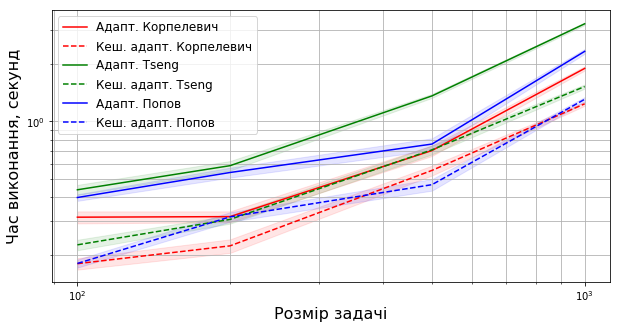

In [48]:
save_results_to_img_pm(times, sizes,
    fn='2/adapt/time',
    styles=('r-', 'r--', 'g-', 'g--', 'b-', 'b--'),
    title='Час виконання, секунд')

# Задача 4

In [49]:
def generate_tridiagonal_matrix(size: int) -> np.matrix:
    d = np.zeros((size, size))
    for row in range(size):
        d[row, row] = 4
        if row != 0:
            d[row, row - 1] = 1
        if row + 1 != size:
            d[row, row + 1] = -2
    c = -np.ones(size)
    return d, c

In [50]:
sizes = (500, 1_000, 2_000, 5_000)
algos = ('Адапт. Корпелевич', 'Кеш. адапт. Корпелевич',
         'Адапт. Tseng', 'Кеш. адапт. Tseng',
         'Адапт. Попов', 'Кеш. адапт. Попов')
iters, times = {algo: {} for algo in algos}, {algo: {} for algo in algos}

In [51]:
for size in sizes:
    print(f'Розмір задачі = {size}:')
    d, c = generate_tridiagonal_matrix(size)

    def f(x: np.array) -> np.array:
        y = np.hstack([[0], x, [0]])
        f1 = y[1:-1] ** 2 + y[:-2] ** 2 + y[1:-1] * y[:-2] + y[1:-1] * y[2:]
        return f1 + d.dot(x) + c

    print('\tАдапт. Корпелевич:', end=' ')
    _, iters['Адапт. Корпелевич'][size], times['Адапт. Корпелевич'][size] = \
          adaptive_korpelevich(x_initial=np.ones(size), tau=.4, lambda_initial=1,
                               A=f, ProjectionOntoC=lambda x: np.maximum(x, np.zeros(x.shape[0])),
                               tolerance=1e-6, max_iterations=1e4, debug=True)

    print('\tКеш. адапт. Корпелевич:', end=' ')
    _, iters['Кеш. адапт. Корпелевич'][size], times['Кеш. адапт. Корпелевич'][size] = \
          cached_adaptive_korpelevich(x_initial=np.ones(size), tau=.4, lambda_initial=1,
                                      A=f, ProjectionOntoC=lambda x: np.maximum(x, np.zeros(x.shape[0])),
                                      tolerance=1e-6, max_iterations=1e4, debug=True)

    print('\tАдапт. Tseng:', end=' ')
    _, iters['Адапт. Tseng'][size], times['Адапт. Tseng'][size] = \
          adaptive_tseng(x_initial=np.ones(size), tau=.4, lambda_initial=1,
                         A=f, ProjectionOntoC=lambda x: np.maximum(x, np.zeros(x.shape[0])),
                         tolerance=1e-6, max_iterations=1e4, debug=True)

    print('\tКеш. адапт. Tseng:', end=' ')
    _, iters['Кеш. адапт. Tseng'][size], times['Кеш. адапт. Tseng'][size] = \
          cached_adaptive_tseng(x_initial=np.ones(size), tau=.4, lambda_initial=1,
                                A=f, ProjectionOntoC=lambda x: np.maximum(x, np.zeros(x.shape[0])),
                                tolerance=1e-6, max_iterations=1e4, debug=True)

    print('\tАдапт. Попов:', end=' ')
    _, iters['Адапт. Попов'][size], times['Адапт. Попов'][size] = \
          adaptive_popov(x_initial=np.ones(size), y_initial=np.ones(size),
                         tau=.4, lambda_initial=1,
                         A=f, ProjectionOntoC=lambda x: np.maximum(x, np.zeros(x.shape[0])),
                         tolerance=1e-6, max_iterations=1e4, debug=True)

    print("\tКеш. адапт. Попов: ", end="")
    _, iters['Кеш. адапт. Попов'][size], times['Кеш. адапт. Попов'][size] = \
          cached_adaptive_popov(x_initial=np.ones(size), y_initial=np.ones(size),
                                tau=.4, lambda_initial=1,
                                A=f, ProjectionOntoC=lambda x: np.maximum(x, np.zeros(x.shape[0])),
                                tolerance=1e-6, max_iterations=1e4, debug=True)
    
    print()


Розмір задачі = 500:
	Адапт. Корпелевич: Took 111 iterations and 0.17 seconds to converge.
	Кеш. адапт. Корпелевич: Took 111 iterations and 0.06 seconds to converge.
	Адапт. Tseng: Took 558 iterations and 0.96 seconds to converge.
	Кеш. адапт. Tseng: Took 558 iterations and 0.29 seconds to converge.
	Адапт. Попов: Took 87 iterations and 0.15 seconds to converge.
	Кеш. адапт. Попов: Took 87 iterations and 0.03 seconds to converge.

Розмір задачі = 1000:
	Адапт. Корпелевич: Took 113 iterations and 0.38 seconds to converge.
	Кеш. адапт. Корпелевич: Took 113 iterations and 0.10 seconds to converge.
	Адапт. Tseng: Took 572 iterations and 1.83 seconds to converge.
	Кеш. адапт. Tseng: Took 572 iterations and 0.52 seconds to converge.
	Адапт. Попов: Took 89 iterations and 0.18 seconds to converge.
	Кеш. адапт. Попов: Took 89 iterations and 0.04 seconds to converge.

Розмір задачі = 2000:
	Адапт. Корпелевич: Took 116 iterations and 1.50 seconds to converge.
	Кеш. адапт. Корпелевич: Took 116 ite

In [52]:
save_results_to_tbl(times, sizes,
    fn='4/adapt/time',
    caption='Час виконання, секунд')
save_results_to_tbl(iters, sizes,
    fn='4/adapt/iter',
    caption='Число ітерацій')

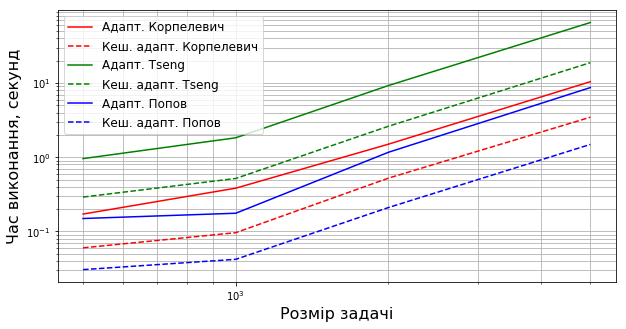

In [53]:
save_results_to_img(times, sizes,
    fn='4/adapt/time',
    styles=('r-', 'r--', 'g-', 'g--', 'b-', 'b--'),
    title='Час виконання, секунд')

In [54]:
def generate_sparse_tridiagonal_matrix(size: int) -> np.matrix:
    data, rows, cols = [], [], []
    for row in range(size):
        if row != 0:
            rows.append(row)
            cols.append(row - 1)
            data.append(1)
        rows.append(row)
        cols.append(row)
        data.append(4)
        if row + 1 != size:
            rows.append(row)
            cols.append(row + 1)
            data.append(-2)
    d = sparse.coo_matrix((data, (rows, cols)), shape=(size, size))
    c = -np.ones(size)
    return d, c

In [55]:
sizes = (20_000, 50_000, 100_000, 200_000)
algos = ('Адапт. Корпелевич', 'Кеш. адапт. Корпелевич',
         'Адапт. Tseng', 'Кеш. адапт. Tseng',
         'Адапт. Попов', 'Кеш. адапт. Попов')
iters, times = {algo: {} for algo in algos}, {algo: {} for algo in algos}

In [ ]:
for size in sizes:
    print(f'Розмір задачі = {size}:')
    d, c = generate_sparse_tridiagonal_matrix(size)

    def f(x: np.array) -> np.array:
        y = np.hstack([[0], x, [0]])
        f1 = y[1:-1] ** 2 + y[:-2] ** 2 + y[1:-1] * y[:-2] + y[1:-1] * y[2:]
        return f1 + d.dot(x) + c

    print('\tАдапт. Корпелевич:', end=' ')
    _, iters['Адапт. Корпелевич'][size], times['Адапт. Корпелевич'][size] = \
          adaptive_korpelevich(x_initial=np.zeros(size), tau=.4, lambda_initial=1,
                               A=f, ProjectionOntoC=lambda x: np.maximum(x, np.zeros(x.shape[0])),
                               tolerance=1e-6, max_iterations=1e4, debug=True)

    print('\tКеш. адапт. Корпелевич:', end=' ')
    _, iters['Кеш. адапт. Корпелевич'][size], times['Кеш. адапт. Корпелевич'][size] = \
          cached_adaptive_korpelevich(x_initial=np.zeros(size), tau=.4, lambda_initial=1,
                                      A=f, ProjectionOntoC=lambda x: np.maximum(x, np.zeros(x.shape[0])),
                                      tolerance=1e-6, max_iterations=1e4, debug=True)

    print('\tАдапт. Tseng:', end=' ')
    _, iters['Адапт. Tseng'][size], times['Адапт. Tseng'][size] = \
          adaptive_tseng(x_initial=np.zeros(size), tau=.4, lambda_initial=1,
                         A=f, ProjectionOntoC=lambda x: np.maximum(x, np.zeros(x.shape[0])),
                         tolerance=1e-6, max_iterations=1e4, debug=True)

    print('\tКеш. адапт. Tseng:', end=' ')
    _, iters['Кеш. адапт. Tseng'][size], times['Кеш. адапт. Tseng'][size] = \
          cached_adaptive_tseng(x_initial=np.zeros(size), tau=.4, lambda_initial=1,
                                A=f, ProjectionOntoC=lambda x: np.maximum(x, np.zeros(x.shape[0])),
                                tolerance=1e-6, max_iterations=1e4, debug=True)

    print('\tАдапт. Попов:', end=' ')
    _, iters['Адапт. Попов'][size], times['Адапт. Попов'][size] = \
          adaptive_popov(x_initial=np.zeros(size), y_initial=np.zeros(size),
                         tau=.4, lambda_initial=1,
                         A=f, ProjectionOntoC=lambda x: np.maximum(x, np.zeros(x.shape[0])),
                         tolerance=1e-6, max_iterations=1e4, debug=True)

    print("\tКеш. адапт. Попов: ", end="")
    _, iters['Кеш. адапт. Попов'][size], times['Кеш. адапт. Попов'][size] = \
          cached_adaptive_popov(x_initial=np.zeros(size), y_initial=np.zeros(size),
                                tau=.4, lambda_initial=1,
                                A=f, ProjectionOntoC=lambda x: np.maximum(x, np.zeros(x.shape[0])),
                                tolerance=1e-6, max_iterations=1e4, debug=True)
    
    print()


Розмір задачі = 20000:
	Адапт. Корпелевич: Took 74 iterations and 0.15 seconds to converge.
	Кеш. адапт. Корпелевич: Took 74 iterations and 0.07 seconds to converge.
	Адапт. Tseng: Took 388 iterations and 0.91 seconds to converge.
	Кеш. адапт. Tseng: Took 388 iterations and 0.47 seconds to converge.
	Адапт. Попов: Took 71 iterations and 0.20 seconds to converge.
	Кеш. адапт. Попов: Took 71 iterations and 0.13 seconds to converge.

Розмір задачі = 50000:
	Адапт. Корпелевич: Took 76 iterations and 1.28 seconds to converge.
	Кеш. адапт. Корпелевич: Took 76 iterations and 0.53 seconds to converge.
	Адапт. Tseng: Took 399 iterations and 4.90 seconds to converge.
	Кеш. адапт. Tseng: Took 399 iterations and 2.38 seconds to converge.
	Адапт. Попов: Took 73 iterations and 0.67 seconds to converge.
	Кеш. адапт. Попов: Took 73 iterations and 0.14 seconds to converge.

Розмір задачі = 100000:
	Адапт. Корпелевич: Took 77 iterations and 2.36 seconds to converge.
	Кеш. адапт. Корпелевич: Took 77 iter

In [ ]:
save_results_to_tbl(times, sizes,
    fn='4/sparse/adapt/time',
    caption='Час виконання, секунд')
save_results_to_tbl(iters, sizes,
    fn='4/sparse/adapt/iter',
    caption='Число ітерацій')

In [ ]:
save_results_to_img(times, sizes,
    fn='4/sparse/adapt/time',
    styles=('r-', 'r--', 'g-', 'g--', 'b-', 'b--'),
    title='Час виконання, секунд')